# Plot the compiled infection matrix

In [16]:
import os 
import pandas as pd 
from tqdm import tqdm
from collections import Counter, defaultdict
from itertools import product
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, matthews_corrcoef


In [17]:
path_benchmark = "/media/concha-eloko/Linux/PPT_clean/benchmark"

results_bench_df = pd.read_csv(f"{path_benchmark}/Prediction_results.v5.matrices.tsv", sep = "\t", index_col = False, header = 0)
results_bench_df["SpikeHunter_prediction"] = [kltype.replace("K", "KL") for kltype in results_bench_df["SpikeHunter_prediction"] if kltype.count("KL")==0]

phages_to_ignore = ["K2064PH2","K2069PH1","OBHDAGOG","A1e","A1f","A3a","EONHMLJF"]
working_df = results_bench_df[~results_bench_df["phage"].isin(phages_to_ignore)]

In [18]:
working_df.columns

Index(['phage', 'protein', 'Folds', 'TropiGAT_new_UF_prediction',
       'TropiGAT_new_UF_good_calls', 'TropiSEQ_prediction',
       'TropiSEQ_good_calls', 'SpikeHunter_prediction',
       'SpikeHunter_good_calls', 'Targets'],
      dtype='object')

In [19]:
working_df

,phage,protein,Folds,TropiGAT_new_UF_prediction,TropiGAT_new_UF_good_calls,TropiSEQ_prediction,TropiSEQ_good_calls,SpikeHunter_prediction,SpikeHunter_good_calls,Targets
0,A1a,A1a_00014,right-handed beta-helix,KL28:0.866 ; KL117:0.739 ; KL45:0.534,0,KL151:0.599 ; KL37:0.235 ; KL164:0.195 ; KL61:...,KL151,KL151,KL151,KL151
1,A1a,A1a_00002,6-bladed beta-propeller,KL123:1.0 ; KL4:0.996 ; KL55:0.985 ; KL124:0.9...,0,KL102:0.737 ; KL7:0.448 ; KL37:0.235 ; KL164:0...,0,No_hits,0,KL151
2,A1b,A1b_00036,6-bladed beta-propeller,KL123:1.0 ; KL4:0.997 ; KL55:0.981 ; KL124:0.9...,0,KL102:0.737 ; KL7:0.448 ; KL37:0.235 ; KL164:0...,0,No_hits,0,KL157
3,A1b,A1b_00048,right-handed beta-helix,KL28:0.961 ; KL71:0.959 ; KL157:0.927 ; KL155:...,KL157,KL157:0.469 ; KL37:0.235 ; KL164:0.195 ; KL61:...,KL157,KL157,KL157,KL157
4,A1c,A1c_00034,right-handed beta-helix,KL128:0.971 ; KL21:0.872 ; KL43:0.812 ; KL34:0...,0,No_hits,0,No_hits,0,KL1
...,...,...,...,...,...,...,...,...,...,...
234,S13a,S13a_00036,right-handed beta-helix,KL57:0.947 ; KL60:0.779 ; KL122:0.707 ; KL53:0...,0,KL38:0.38 ; KL37:0.235 ; KL164:0.195 ; KL61:0....,0,KL38,0,"KL102,KL149"
235,S13b,S13b_00058,right-handed beta-helix,KL47:0.996 ; KL34:0.961 ; KL26:0.906 ; KL64:0....,0,KL63:0.641 ; KL37:0.235 ; KL164:0.195 ; KL61:0...,KL63,No_hits,0,KL63
236,S13c,S13c_00055,right-handed beta-helix,KL38:0.95 ; KL123:0.854 ; KL127:0.786 ; KL27:0...,0,KL38:0.376 ; KL37:0.235 ; KL164:0.195 ; KL61:0...,0,KL38,0,"KL102,KL149"
237,S13d,S13d_00057,right-handed beta-helix,KL14:0.979 ; KL64:0.933 ; KL21:0.714 ; KL26:0....,KL14,KL14:0.951 ; KL64:0.307 ; KL164:0.195 ; KL61:0...,KL14,KL14,KL14,KL14


In [20]:
path_finetuning = "/media/concha-eloko/Linux/PPT_clean/in_vitro/fine_tuning"

bea_df = pd.read_csv(f"{path_finetuning}/bea_fine_tuning.df", sep = "\t", header = 0)
bea_df["Protein"] = bea_df["Protein"].apply(lambda x : x.replace("_", "__"))
pool_bea = set([kltype.strip() for kltypes in bea_df["Target"] for kltype in kltypes.split(",") if kltype.count("wzi") == 0 if kltype.count("pass") == 0])

ferriol_df = pd.read_csv(f"{path_finetuning}/ferriol_fine_tuning.df", sep = "\t", header = 0)
#ferriol_df["Target"] = ferriol_df["Target"].apply(lambda x : x.replace("K", "KL"))
pool_ferriol = set([kltype.strip() for kltypes in ferriol_df["Target"] for kltype in kltypes.split(",") if kltype.count("wzi") == 0 if kltype.count("pass") == 0])

towndsend_df = pd.read_csv(f"{path_finetuning}/towndsend_fine_tuning.df", sep = "\t", header = 0)
towndsend_df["Protein"] = towndsend_df["Protein"].apply(lambda x : x.replace("_", "__"))
pool_towndsend = set([kltype.strip() for kltypes in towndsend_df["Target"] for kltype in kltypes.split(",") if kltype.count("wzi") == 0 if kltype.count("pass") == 0])

dico_matrices = {"ferriol" : {"matrix" : ferriol_df, "pool" : pool_ferriol}, 
                 "bea" : {"matrix": bea_df, "pool" : pool_bea}, 
                 "towndsend" : {"matrix" : towndsend_df, "pool" : pool_towndsend}}

# targets dico : 
dico_hits = {}
for author in dico_matrices :
    matrix = dico_matrices[author]["matrix"]
    for _, row in matrix.iterrows() : 
        for phage in matrix["Phages"].unique() : 
            if phage not in phages_to_ignore :
                all_targets = set()
                targets = matrix[matrix["Phages"] == phage]["Target"].values
                for calls in targets : 
                    actual_targets = [x.strip() for x in calls.split(",")]
                    all_targets.update(actual_targets)
                dico_hits[phage] = all_targets




In [21]:
def get_calls_metrics(raw_df , with_fold = False ,top_n = 15, to_ignore = []) :
    total_calls = []
    TropiGAT_good_calls = []
    TropiSeq_good_calls = []
    
    for phage in raw_df["phage"].unique() : 
        if phage not in to_ignore :
            tmp_df = raw_df[raw_df["phage"] == phage]
            targets_set = set(tmp_df["Targets"].tolist()[0].split(","))
            n_targets = len(targets_set)
            combinations = set(product([phage], list(targets_set)))
            total_calls = total_calls + list(combinations)
            if "".join((list(targets_set)[0])).count("pass") == 0 : 
                # TropiGAT calls : 
                call_tropigat = set()
                for calls in tmp_df["TropiGAT_new_UF_prediction"] :
                    top_n_predictions = [x.split(":")[0].strip() for x in calls.split(";")][0:top_n-1]
                    call_tropigat.update(top_n_predictions)
                good_calls_tropigat = call_tropigat.intersection(targets_set)
                if len(good_calls_tropigat) > 0 :
                    for kltype in good_calls_tropigat : 
                        a = (phage , kltype)
                        TropiGAT_good_calls.append(a)
                # TropiSeq calls : 
                call_tropiseq = set()
                for calls in tmp_df["TropiSEQ_prediction"] :
                    top_n_predictions = [x.split(":")[0].strip() for x in calls.split(";")][0:top_n-1]
                    call_tropiseq.update(top_n_predictions)
                good_calls_tropiseq = call_tropiseq.intersection(targets_set)
                if len(good_calls_tropiseq) > 0 :
                    for kltype in good_calls_tropiseq : 
                        a = (phage , kltype)
                        TropiSeq_good_calls.append(a)
                        
                        
    all_calls = set(TropiGAT_good_calls).union(set(TropiSeq_good_calls))

    return total_calls, all_calls , TropiGAT_good_calls , TropiSeq_good_calls

In [29]:
# Compute :
total_calls, all_calls , TropiGAT_good_calls , _ = get_calls_metrics(working_df, top_n = 20, to_ignore = phages_to_ignore)
total_calls, all_calls , _ , TropiSeq_good_calls = get_calls_metrics(working_df, top_n = 20, to_ignore = phages_to_ignore)

# TropiSeq : 
Tropiseq_unique = set(TropiSeq_good_calls) - set(TropiGAT_good_calls)
# TropiGAT :
Tropigat_unique = set(TropiGAT_good_calls) - set(TropiSeq_good_calls)
# Combo :
common_ground = set(TropiGAT_good_calls) & set(TropiSeq_good_calls)

In [38]:
Tropigat_unique

{('D7c', 'KL28'),
 ('DIMCIIMF', 'KL28'),
 ('DJLANJJD', 'KL4'),
 ('DJLANJJD', 'KL57'),
 ('EHPPICDA', 'KL57'),
 ('EKPIEFBL', 'KL4'),
 ('EKPIEFBL', 'KL57'),
 ('FADJDIKG', 'KL4'),
 ('FADJDIKG', 'KL57'),
 ('FADJDIKG', 'KL64'),
 ('GCLPFEGH', 'KL4'),
 ('GCLPFEGH', 'KL57'),
 ('INMBNBLA', 'KL57'),
 ('IPGJFKPH', 'KL4'),
 ('IPGJFKPH', 'KL57'),
 ('K13PH07C1S', 'KL13'),
 ('K14PH164C1', 'KL14'),
 ('K26PH128C1', 'KL26'),
 ('K29PH164C1', 'KL24'),
 ('K30lambda2_2', 'KL26'),
 ('K30lambda2_2', 'KL30'),
 ('K30lambda2_2', 'KL36'),
 ('K30lambda2_2', 'KL64'),
 ('K30lambda2_2', 'KL67'),
 ('K35PH164C3', 'KL30'),
 ('K41P2', 'KL39'),
 ('K43PH164C1', 'KL43'),
 ('K46PH129', 'KL46'),
 ('K4PH164', 'KL4'),
 ('K52PH129C1', 'KL39'),
 ('K60PH164C1', 'KL60'),
 ('K65PH164', 'KL27'),
 ('K65PH164', 'KL36'),
 ('K65PH164', 'KL62'),
 ('K71PH129C1', 'KL71'),
 ('K7PH164C4', 'KL27'),
 ('K7PH164C4', 'KL39'),
 ('K7PH164C4', 'KL52'),
 ('K7PH164C4', 'KL64'),
 ('K8PH128', 'KL1'),
 ('POFPNCPI', 'KL4'),
 ('POFPNCPI', 'KL57')}

In [31]:
# Get the y axis :
big_pool = []

for author in dico_matrices :
    big_pool = big_pool + list(dico_matrices[author]["pool"])
    
big_pool = list(set(big_pool))
big_pool.sort(key = lambda x : int(x.split("KL")[1]))

# Get the x axis :
phages_vectors = {}

for author in dico_matrices :
    matrix = dico_matrices[author]["matrix"]
    for phage in matrix["Phages"].unique() :
        vector = []
        if phage not in phages_to_ignore :
            if str(dico_hits[phage]).count("pass") == 0 :
                for _,kltype in enumerate(big_pool) :
                    if kltype in dico_matrices[author]["pool"] :
                        if kltype in dico_hits[phage] :
                            pair = (phage, kltype)
                            if pair in Tropigat_unique :
                                vector.append(0.5)
                            elif pair in Tropiseq_unique :
                                vector.append(0.75)
                            elif pair in common_ground :
                                vector.append(1)
                            else :
                                vector.append(0.25)
                        else :
                            vector.append(0.1)
                    else :
                        vector.append(0)
                phages_vectors[phage] = vector
                
df = pd.DataFrame(phages_vectors)
transposed_df = df.T
transposed_df.columns = big_pool


In [46]:
transposed_df

,KL1,KL2,KL3,KL4,KL5,KL6,KL7,KL8,KL9,KL10,...,KL126,KL134,KL136,KL139,KL140,KL144,KL149,KL151,KL157,KL158
K10PH82C1,0.1,0.10,0.00,0.1,0.1,0.1,0.1,0.1,0.1,0.25,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00
K11PH164C1,0.1,0.10,0.00,0.1,0.1,0.1,0.1,0.1,0.1,0.10,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00
K12P1_1,0.1,0.10,0.00,0.1,0.1,0.1,0.1,0.1,0.1,0.10,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00
K13PH07C1L,0.1,0.10,0.00,0.1,0.1,0.1,0.1,0.1,0.1,0.10,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00
K13PH07C1S,0.1,0.10,0.00,0.1,0.1,0.1,0.1,0.1,0.1,0.10,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NJHLHPIG,0.0,0.10,0.10,0.1,0.0,0.0,0.0,0.0,0.0,0.00,...,0.0,0.0,0.0,0.0,0.0,0.1,0.0,0.0,0.0,0.10
OPBIHMGG,0.0,0.10,1.00,0.1,0.0,0.0,0.0,0.0,0.0,0.00,...,0.0,0.0,0.0,0.0,0.0,0.1,0.0,0.0,0.0,0.10
PFOEGONH,0.0,0.10,1.00,0.1,0.0,0.0,0.0,0.0,0.0,0.00,...,0.0,0.0,0.0,0.0,0.0,0.1,0.0,0.0,0.0,0.10
POFPNCPI,0.0,0.25,0.25,0.5,0.0,0.0,0.0,0.0,0.0,0.00,...,0.0,0.0,0.0,0.0,0.0,0.1,0.0,0.0,0.0,0.25


> Add the SpikeHunter calls: 

In [59]:
spikehunter = [('A1a', 'A1a_00014', 'KL151', 1), ('A1b', 'A1b_00048', 'KL157', 1), ('A1h', 'A1h_00021', 'KL2', 1),
 ('A3b', 'A3b_00021', 'KL30', 1), ('D7b', 'D7b_00043', 'KL140', 1), ('D7c', 'D7c_00007', 'KL28', 1),
 ('HIIECEMK', 'HIIECEMK_00054', 'KL2', 1), ('K15PH90', 'K15PH90__cds_55', 'KL15', 1),
 ('K17alfa62', 'K17alfa62__cds_64', 'KL17', 1), ('K17alfa62', 'K17alfa62__cds_66', 'KL62', 1),
 ('K18PH07C1', 'K18PH07C1__cds_243', 'KL18', 1), ('K22PH164C1', 'K22PH164C1__cds_10', 'KL22', 1),
 ('K24PH164C1', 'K24PH164C1__cds_8', 'KL24', 1), ('K25PH129C1', 'K25PH129C1__cds_60', 'KL25', 1),
 ('K27PH129C1', 'K27PH129C1__cds_48', 'KL27', 1), ('K2PH164C2', 'K2PH164C2__cds_24', 'KL2', 1),
 ('K35PH164C3', 'K35PH164C3__cds_48', 'KL35', 1), ('K38PH09C2', 'K38PH09C2__cds_24', 'KL38', 1),
 ('K42PH8', 'K42PH8__cds_48', 'KL42', 1), ('K45PH128C2', 'K45PH128C2__cds_237', 'KL71', 1),
 ('K53PH164C2', 'K53PH164C2__cds_24', 'KL53', 1),
 ('K54lambda1_1_1', 'K54lambda1_1_1__cds_238', 'KL24', 1),
 ('K57lambda1_2', 'K57lambda1_2__cds_92', 'KL57', 1),
 ('K60PH164C1', 'K60PH164C1__cds_94', 'KL18', 1), ('K60PH164C1', 'K60PH164C1__cds_96', 'KL60', 1),
 ('K64PH164C4', 'K64PH164C4__cds_24', 'KL64', 1), ('K66PH128C1', 'K66PH128C1__cds_59', 'KL66', 1),
 ('K71PH129C1', 'K71PH129C1__cds_55', 'KL71', 1), ('K9PH25C2', 'K9PH25C2__cds_76', 'KL9', 1),
 ('KBDEFBCI', 'KBDEFBCI_00052', 'KL35', 1), ('LCALLHIG', 'LCALLHIG_00050', 'KL3', 1),
 ('M12a', 'M12a_00031', 'KL139', 1), ('NBNDMPCG', 'NBNDMPCG_00161', 'KL35', 1),
 ('NBNDMPCG', 'NBNDMPCG_00163', 'KL2', 1), ('NJHLHPIG', 'NJHLHPIG_00055', 'KL35', 1),
 ('OPBIHMGG', 'OPBIHMGG_00067', 'KL3', 1), ('P4a', 'P4a_00011', 'KL140', 1),
 ('P4b', 'P4b_00025', 'KL140', 1), ('PFOEGONH', 'PFOEGONH_00078', 'KL3', 1),
 ('PP187', 'PP187_gp230', 'KL110', 1), ('S10a', 'S10a_00097', 'KL25', 1),
 ('S11a', 'S11a_00036', 'KL25', 1), ('S13d', 'S13d_00057', 'KL14', 1),
 ('S13e', 'S13e_00021', 'KL136', 1)]


spikehunter_clean_calls = [(item[0], item[2]) for item in spikehunter]


In [60]:
spikehunter_clean_calls

[('A1a', 'KL151'),
 ('A1b', 'KL157'),
 ('A1h', 'KL2'),
 ('A3b', 'KL30'),
 ('D7b', 'KL140'),
 ('D7c', 'KL28'),
 ('HIIECEMK', 'KL2'),
 ('K15PH90', 'KL15'),
 ('K17alfa62', 'KL17'),
 ('K17alfa62', 'KL62'),
 ('K18PH07C1', 'KL18'),
 ('K22PH164C1', 'KL22'),
 ('K24PH164C1', 'KL24'),
 ('K25PH129C1', 'KL25'),
 ('K27PH129C1', 'KL27'),
 ('K2PH164C2', 'KL2'),
 ('K35PH164C3', 'KL35'),
 ('K38PH09C2', 'KL38'),
 ('K42PH8', 'KL42'),
 ('K45PH128C2', 'KL71'),
 ('K53PH164C2', 'KL53'),
 ('K54lambda1_1_1', 'KL24'),
 ('K57lambda1_2', 'KL57'),
 ('K60PH164C1', 'KL18'),
 ('K60PH164C1', 'KL60'),
 ('K64PH164C4', 'KL64'),
 ('K66PH128C1', 'KL66'),
 ('K71PH129C1', 'KL71'),
 ('K9PH25C2', 'KL9'),
 ('KBDEFBCI', 'KL35'),
 ('LCALLHIG', 'KL3'),
 ('M12a', 'KL139'),
 ('NBNDMPCG', 'KL35'),
 ('NBNDMPCG', 'KL2'),
 ('NJHLHPIG', 'KL35'),
 ('OPBIHMGG', 'KL3'),
 ('P4a', 'KL140'),
 ('P4b', 'KL140'),
 ('PFOEGONH', 'KL3'),
 ('PP187', 'KL110'),
 ('S10a', 'KL25'),
 ('S11a', 'KL25'),
 ('S13d', 'KL14'),
 ('S13e', 'KL136')]

In [68]:
# Get the y axis :
big_pool = []

for author in dico_matrices :
    big_pool = big_pool + list(dico_matrices[author]["pool"])
    
big_pool = list(set(big_pool))
big_pool.sort(key = lambda x : int(x.split("KL")[1]))

# Get the x axis :
phages_vectors = {}

for author in dico_matrices :
    matrix = dico_matrices[author]["matrix"]
    for phage in matrix["Phages"].unique() :
        vector = []
        if phage not in phages_to_ignore :
            if str(dico_hits[phage]).count("pass") == 0 :
                for _,kltype in enumerate(big_pool) :
                    if kltype in dico_matrices[author]["pool"] :
                        if kltype in dico_hits[phage] :
                            pair = (phage, kltype)
                            if pair in spikehunter_clean_calls :
                                vector.append(1)
                            else :
                                vector.append(0)
                        else :
                            vector.append(0)
                    else :
                        vector.append(0)
                phages_vectors[phage] = vector
                
df = pd.DataFrame(phages_vectors)
transposed_df_2 = df.T
transposed_df_2.columns = big_pool

In [86]:
integrity_check = transposed_df_2.copy()
integrity_check.index.name = "phage"
integrity_check

,KL1,KL2,KL3,KL4,KL5,KL6,KL7,KL8,KL9,KL10,...,KL126,KL134,KL136,KL139,KL140,KL144,KL149,KL151,KL157,KL158
phage,,,,,,,,,,,,,,,,,,,,,
K10PH82C1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
K11PH164C1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
K12P1_1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
K13PH07C1L,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
K13PH07C1S,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NJHLHPIG,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
OPBIHMGG,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
PFOEGONH,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [100]:
integrity_check[(integrity_check.index == "PP187")]["KL110"] , sum(integrity_check[(integrity_check.index == "PP187")].values[0])
integrity_check[(integrity_check.index == "K17alfa62")]["KL17"] , sum(integrity_check[(integrity_check.index == "K17alfa62")].values[0])

(phage
 K17alfa62    1
 Name: KL17, dtype: int64,
 2)

> Plot the matrix

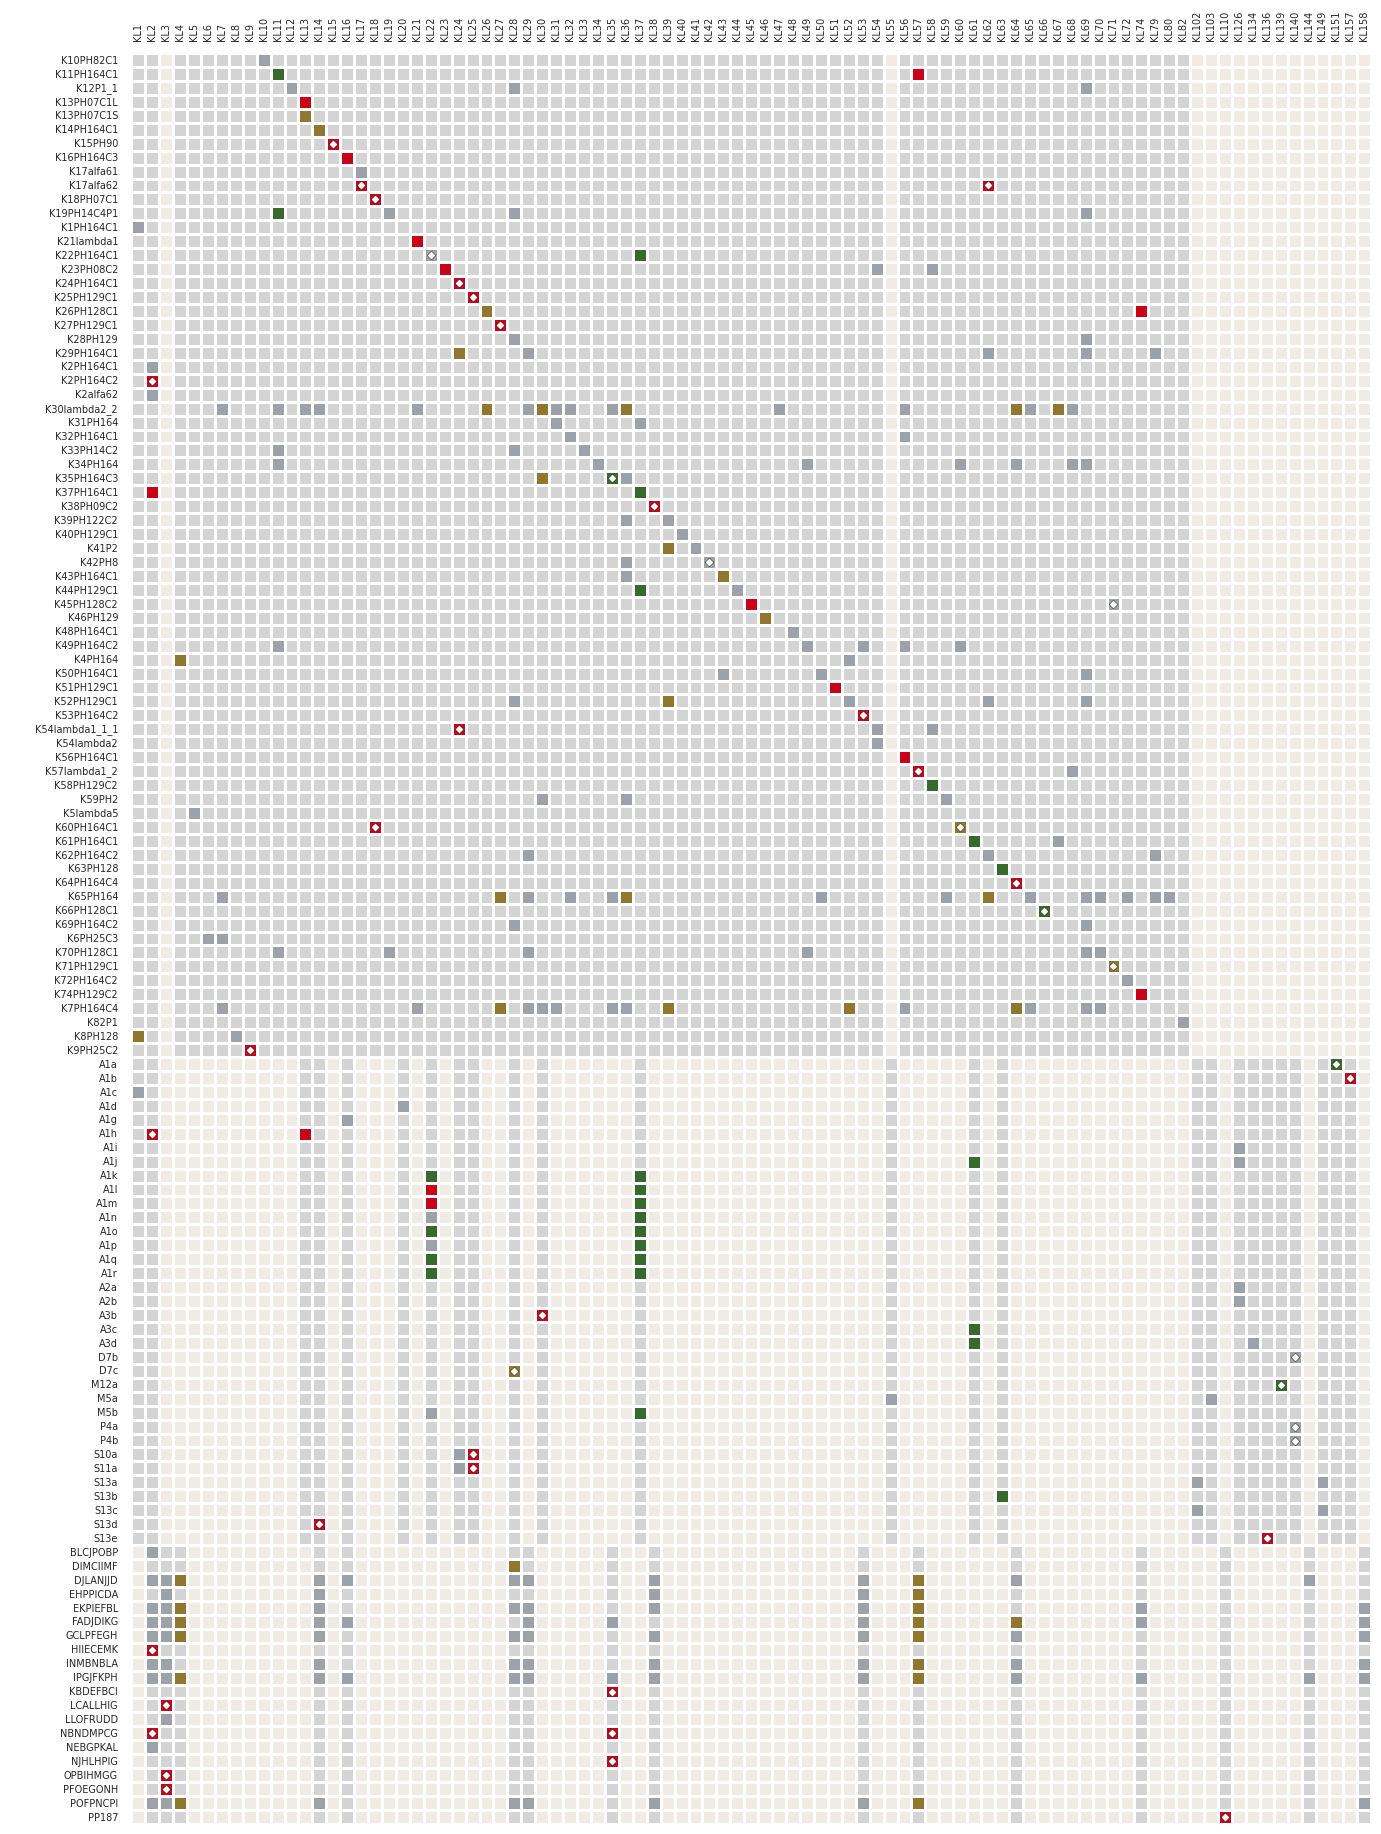

In [110]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib.colors import ListedColormap

path_panels = "/media/concha-eloko/Linux/papers/PPT/reviewed_new_figures/panels"

custom_cmap_dict = {
    0: '#F0ECE5',
    0.1: '#B6BBC4',
    0.25 : "#555555", #7D7C7C
    0.5 : "#C9980B",
    0.75 : "#0A5C36",  #3A5A40
    1: '#C80018',    
}

custom_cmap = plt.matplotlib.colors.LinearSegmentedColormap.from_list('custom_cmap', list(custom_cmap_dict.values()))
f,ax = plt.subplots(figsize=(16, 23))

sns.set(style="white", palette="binary")
sns_plot= sns.heatmap(transposed_df, linecolor='white', 
                      annot=None, 
                      cbar_ax=None, 
                      cbar =False, 
                      linewidths=1.9, 
                      ax = ax, 
                      yticklabels=True,
                      xticklabels= True,
                      cmap = custom_cmap) #rocket_r , mako_r

ax.xaxis.tick_top()
sns_plot.set_ylabel(' ', fontsize=14)
ax.tick_params(top=False)
sns_plot.set_xticklabels(sns_plot.get_xmajorticklabels(), fontsize = 7 ,rotation=90)
sns_plot.set_yticklabels(sns_plot.get_ymajorticklabels(), fontsize = 7) #fontweight='bold'
#f.savefig(path_out+"/matrix_lytic_phages.top40.svg", dpi=600)

# Adding the SpikeHunter data: 
# Get coordinates directly from the matrix
rows, cols = np.where(transposed_df_2 == 1)
y_coords = rows + 0.5  # Center in cell (no inversion)
x_coords = cols + 0.5  # Center in cell

# Plot symbols using precise coordinates
ax.scatter(
    x_coords, y_coords, 
    marker="$\u25C6$",  
    s=40,               # Size adjusted for 100dpi
    color='white',
    edgecolor='black',
    linewidth=0.3,
    zorder=3
)


f.savefig(path_panels+"/matrix_review.png", transparent = True, dpi=600)

plt.show()

***
## Plot depolymerase folds :

In [111]:
path_benchmark = "/media/concha-eloko/Linux/PPT_clean/benchmark"

results_bench_df = pd.read_csv(f"{path_benchmark}/Prediction_results.v5.matrices.tsv", sep = "\t", index_col = False, header = 0)
results_bench_df["SpikeHunter_prediction"] = [kltype.replace("K", "KL") for kltype in results_bench_df["SpikeHunter_prediction"] if kltype.count("KL")==0]

phages_to_ignore = ["K2064PH2","K2069PH1","OBHDAGOG","A1e","A1f","A3a","EONHMLJF"]
working_df = results_bench_df[~results_bench_df["phage"].isin(phages_to_ignore)]

In [112]:
dico_folds = {}

for phage in working_df.phage.unique() :
    folds_arr = working_df[working_df["phage"] == phage]["Folds"].values
    dico_count = dict(Counter(folds_arr))
    dico_folds[phage] = dico_count

In [113]:
dico_folds

{'A1a': {'right-handed beta-helix': 1, '6-bladed beta-propeller': 1},
 'A1b': {'6-bladed beta-propeller': 1, 'right-handed beta-helix': 1},
 'A1c': {'right-handed beta-helix': 1, '6-bladed beta-propeller': 1},
 'A1d': {'6-bladed beta-propeller': 1, 'right-handed beta-helix': 1},
 'A1g': {'6-bladed beta-propeller': 1, 'right-handed beta-helix': 1},
 'A1h': {'6-bladed beta-propeller': 1, 'right-handed beta-helix': 2},
 'A1i': {'6-bladed beta-propeller': 1, 'right-handed beta-helix': 2},
 'A1j': {'6-bladed beta-propeller': 1, 'right-handed beta-helix': 2},
 'A1k': {'6-bladed beta-propeller': 1, 'right-handed beta-helix': 1},
 'A1l': {'6-bladed beta-propeller': 1, 'right-handed beta-helix': 1},
 'A1m': {'right-handed beta-helix': 1, '6-bladed beta-propeller': 1},
 'A1n': {'6-bladed beta-propeller': 1},
 'A1o': {'right-handed beta-helix': 1, '6-bladed beta-propeller': 1},
 'A1p': {'6-bladed beta-propeller': 1},
 'A1q': {'6-bladed beta-propeller': 1, 'right-handed beta-helix': 2},
 'A1r': {'

In [114]:
nested_dico_folds = {}

for author in dico_matrices :
    matrix = dico_matrices[author]["matrix"]
    phages = matrix.Phages.unique()
    subset_dictionary = {key: dico_folds[key] for key in phages if key in dico_folds}
    nested_dico_folds[author] = subset_dictionary
    

In [115]:
df = pd.DataFrame.from_dict(dico_folds, orient='index')
df = df.reindex(transposed_df.index)

In [116]:
df['right-handed beta-helix'] = df['right-handed beta-helix'].fillna(0.0)
df['6-bladed beta-propeller'] = df['6-bladed beta-propeller'].fillna(0.0)
df['triple-helix'] = df['triple-helix'].fillna(0.0)
df['Alpha-alpha toroid'] = df['Alpha-alpha toroid'].fillna(0.0)


In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 127 entries, K10PH82C1 to PP187
Data columns (total 4 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   6-bladed beta-propeller  127 non-null    float64
 1   right-handed beta-helix  127 non-null    float64
 2   triple-helix             127 non-null    float64
 3   Alpha-alpha toroid       127 non-null    float64
dtypes: float64(4)
memory usage: 9.0+ KB


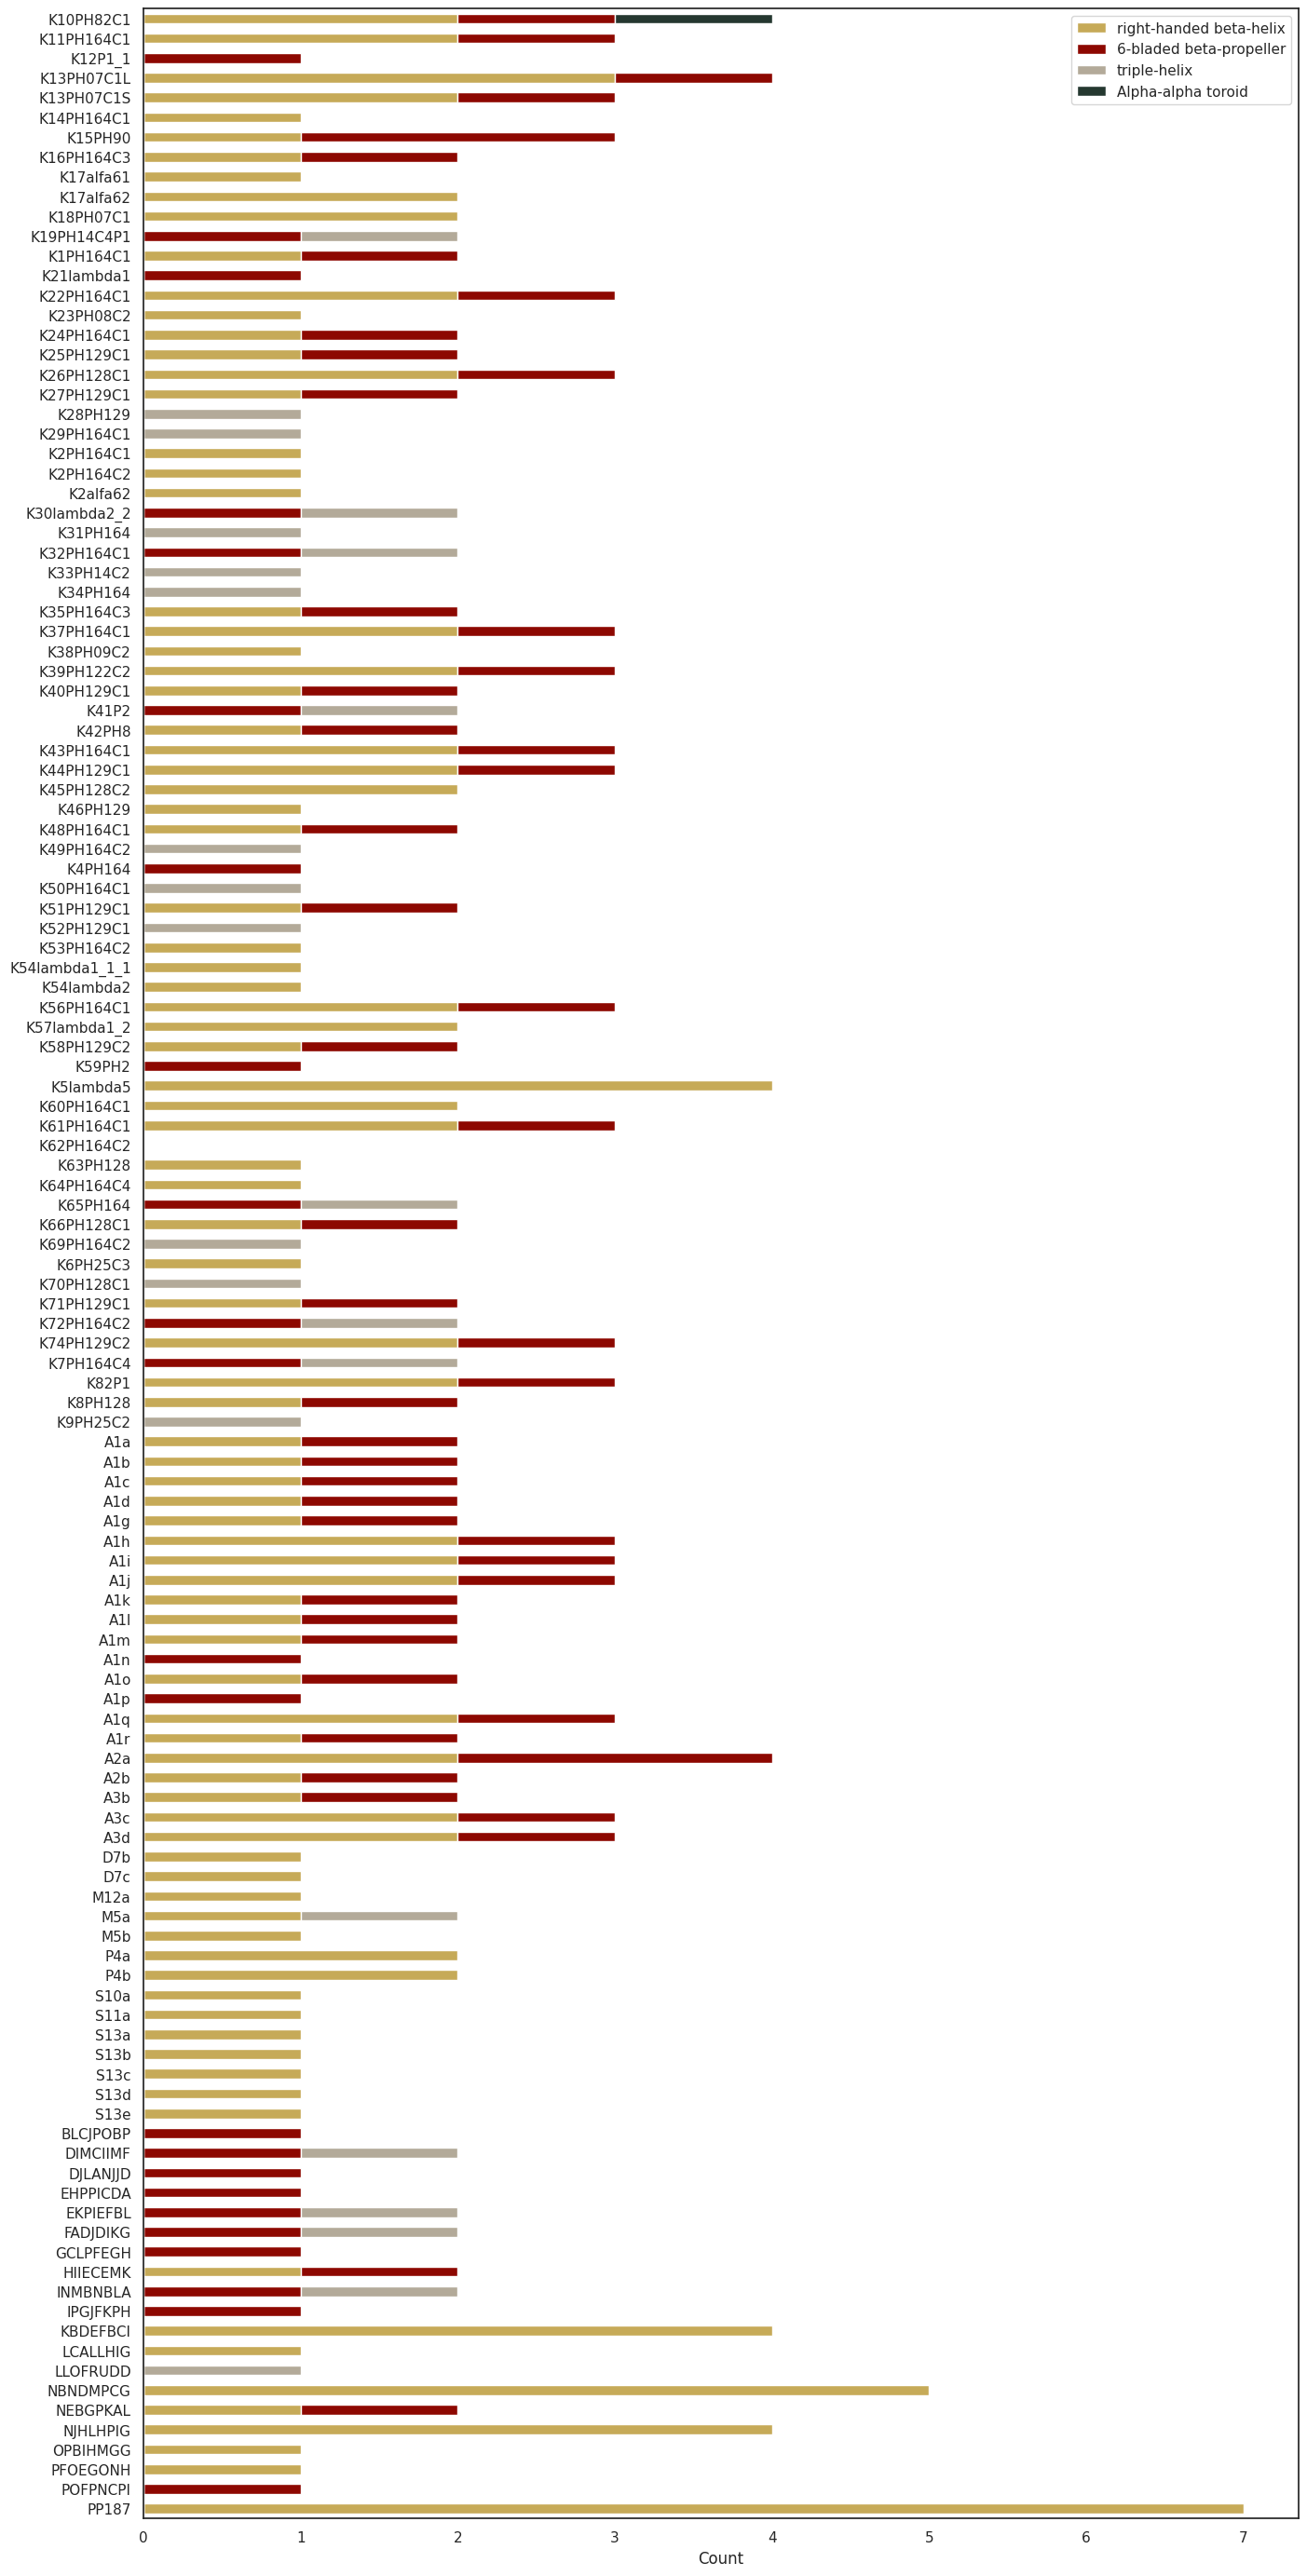

In [120]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

path_out = "/media/concha-eloko/Linux/papers/PPT/figures_draft"

color_dict = {'right-handed beta-helix': '#c6aa58ff', 
              '6-bladed beta-propeller': '#8d0801ff', 
              'triple-helix': '#b3aa99ff',
              'Alpha-alpha toroid' : '#172b23f0'}

figsize = (16, 35)  # Adjust the size for proper visualization
df.plot(kind='barh', stacked=True, color=color_dict.values(), figsize=figsize)
plt.xlabel("Count")
plt.gca().invert_yaxis()
plt.savefig(f'{path_panels}/matrix_y_axis.svg', dpi=300, bbox_inches='tight')
plt.show()



***
# Plot the graph 

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

# create an empty directed graph
G = nx.Graph()

# example dictionary with tuples as keys and their prevalence as values
data = dict(combinations_dom_seq)
data_graph = [(key[0], key[1], value) for key,value in data.items() if value > 1]

# add edges to the graph with weights corresponding to prevalence values
G.add_weighted_edges_from(data_graph)

# get a dictionary of edge weights
edge_weights = nx.get_edge_attributes(G, 'weight')

# define a function to scale edge weights to widths
def scale_width(weight):
    # scale weights to widths between 1 and 10
    return int(1 + weight * 5 / max(edge_weights.values()))

# set the figure size
plt.figure(figsize=(40, 40)) 

# draw the graph with edge widths scaled according to weights
pos = nx.kamada_kawai_layout(G)
#pos = nx.spring_layout(G)

nx.draw(G, pos=pos, node_color='lightblue', with_labels=True, width=[scale_width(w) for w in edge_weights.values()],font_size=25, node_size=4500)

# add edge labels
#edge_labels = nx.get_edge_attributes(G, 'weight')
#nx.draw_networkx_edge_labels(G, pos=pos, edge_labels=edge_labels)

# display the plot
plt.savefig('/media/concha-eloko/Linux/papers/PPT/figures_draft/network_KLtypes.TorpiGAT.0802.svg',format = "svg", transparent = True) 
plt.show()